In [1]:
#@title 2. Final Training Pipeline (Gentle Augmentation)

# --- Step 1: Import all necessary libraries ---
import torch, torch.nn as nn, torch.optim as optim, torchaudio, torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
import glob, os, random, zipfile, requests, re, traceback, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from io import BytesIO

In [3]:
print("--- Starting Final Training Preparation (Gentle Augmentation) ---")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

--- Starting Final Training Preparation (Gentle Augmentation) ---


'cuda'

In [4]:
# --- Step 2: AGGRESSIVE CLEANUP of old data ---
!rm -rf fsdd_data master.zip
print("Cleanup complete.")

Cleanup complete.


In [5]:
# --- Step 3: Download and Unpack FSDD Data ---
print("Downloading and unpacking FSDD data...")
FSDD_URL = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip"
response_fsdd = requests.get(FSDD_URL, stream=True); response_fsdd.raise_for_status()
with zipfile.ZipFile(BytesIO(response_fsdd.content)) as z: z.extractall("fsdd_data")
FSDD_RECS_PATTERN = os.path.join("fsdd_data", "*", "recordings")
found_fsdd_dirs = glob.glob(FSDD_RECS_PATTERN)
if not found_fsdd_dirs: raise FileNotFoundError("Could not find FSDD 'recordings' directory.")
FSDD_DATA_DIR = found_fsdd_dirs[0]
print(f"✅ FSDD data is ready.")

✅ FSDD data is ready.


In [6]:
# --- Step 4: Prepare FSDD File Paths and Labels ---
wav_files = glob.glob(os.path.join(FSDD_DATA_DIR, "*.wav"))
file_paths, labels = [], []
for file_path in wav_files:
    match = re.search(r'(\d+)_', os.path.basename(file_path))
    if match: file_paths.append(file_path); labels.append(int(match.group(1)))
print(f"Found {len(file_paths)} audio files.")

Found 3000 audio files.


In [7]:
# --- Step 5: Define the Final, GENTLY Augmented Dataset Class ---
class SpokenDigitDatasetAugmented(Dataset):
    def __init__(self, file_paths, labels, is_train=False):
        self.file_paths = file_paths
        self.labels = labels
        self.is_train = is_train
        self.target_sample_rate = 48000
        self.target_length_samples = self.target_sample_rate * 1
        self.resampler = T.Resample(orig_freq=8000, new_freq=self.target_sample_rate)
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=self.target_sample_rate, n_fft=2048, hop_length=512, n_mels=128
        )
        # GENTLE AUGMENTATION: Reduced SpecAugment intensity
        if self.is_train:
            self.freq_mask = T.FrequencyMasking(freq_mask_param=15)
            self.time_mask = T.TimeMasking(time_mask_param=20)

    def __len__(self): return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform_8k, _ = torchaudio.load(file_path)
        waveform_48k = self.resampler(waveform_8k)

        # Apply simple noise, the only audio-level augmentation
        if self.is_train and torch.rand(1) < 0.5:
            noise = (torch.rand_like(waveform_48k) * 2 - 1) * 0.004
            waveform_48k += noise

        if waveform_48k.shape[0] > 1: waveform_48k = torch.mean(waveform_48k, dim=0, keepdim=True)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if waveform_48k.shape[1] < self.target_length_samples:
            waveform_48k = torch.nn.functional.pad(waveform_48k, (0, self.target_length_samples - waveform_48k.shape[1]))
        else:
            waveform_48k = waveform_48k[:, :self.target_length_samples]

        spec = self.mel_spectrogram(waveform_48k)
        log_spec = torch.log(torch.clamp(spec, min=1e-6))

        # Apply SpecAugment to the spectrogram for the training set
        if self.is_train:
            log_spec = self.freq_mask(log_spec)
            log_spec = self.time_mask(log_spec)

        return log_spec.squeeze(0).unsqueeze(0), label


In [8]:
# --- Step 6: Create Datasets and DataLoaders ---
train_size = int(0.8 * len(file_paths)); val_size = int(0.1 * len(file_paths))
test_size = len(file_paths) - train_size - val_size
train_dataset = SpokenDigitDatasetAugmented(file_paths[:train_size], labels[:train_size], is_train=True)
val_dataset = SpokenDigitDatasetAugmented(file_paths[train_size:train_size+val_size], labels[train_size:train_size+val_size], is_train=False)
test_dataset = SpokenDigitDatasetAugmented(file_paths[train_size+val_size:], labels[train_size+val_size:], is_train=False)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- Step 7: Final Verification ---
for specs, labels in train_loader:
    input_shape_for_model = specs.shape[1:]
    break
print(f"✅ Final input shape (C, H, W): {input_shape_for_model}")

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

✅ Final input shape (C, H, W): torch.Size([1, 128, 94])


In [9]:
# --- Step 8: Define the Model Architecture (with less dropout for augmented data) ---
class DigitRecognizerCNN(nn.Module):
    def __init__(self, input_shape):
        super(DigitRecognizerCNN, self).__init__()
        self.conv_block_1 = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_block_2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_block_3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv_block_3(self.conv_block_2(self.conv_block_1(dummy_input)))
            flattened_size = dummy_output.flatten(1).shape[1]
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(flattened_size, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 10))
    def forward(self, x):
        x = self.conv_block_1(x); x = self.conv_block_2(x); x = self.conv_block_3(x)
        x = self.classifier(x)
        return x

model = DigitRecognizerCNN(input_shape_for_model).to(device)


In [10]:
# --- Step 9: The Training Loop ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
EPOCHS = 40
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)
best_val_accuracy = 0

print("\n--- Starting Robust Model Training ---")
for epoch in range(EPOCHS):
    model.train(); train_correct, train_total = 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        scheduler.step()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0); train_correct += (predicted == labels).sum().item()
    train_acc = train_correct / train_total

    model.eval(); val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0); val_correct += (predicted == labels).sum().item()
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth') # This will overwrite the baseline model
        print(f"✅ New best model saved with Val Acc: {best_val_accuracy:.4f}")
print(f"\n✅ Training complete. Best validation accuracy: {best_val_accuracy:.4f}")



--- Starting Robust Model Training ---


Epoch 1/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Epoch 1/40 -> Train Acc: 0.1275 | Val Acc: 0.1300
✅ New best model saved with Val Acc: 0.1300


Epoch 2/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/40 -> Train Acc: 0.1829 | Val Acc: 0.3633
✅ New best model saved with Val Acc: 0.3633


Epoch 3/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/40 -> Train Acc: 0.2700 | Val Acc: 0.4967
✅ New best model saved with Val Acc: 0.4967


Epoch 4/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/40 -> Train Acc: 0.2642 | Val Acc: 0.4867


Epoch 5/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/40 -> Train Acc: 0.3108 | Val Acc: 0.5033
✅ New best model saved with Val Acc: 0.5033


Epoch 6/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/40 -> Train Acc: 0.3367 | Val Acc: 0.6300
✅ New best model saved with Val Acc: 0.6300


Epoch 7/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/40 -> Train Acc: 0.3867 | Val Acc: 0.6567
✅ New best model saved with Val Acc: 0.6567


Epoch 8/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/40 -> Train Acc: 0.4358 | Val Acc: 0.6833
✅ New best model saved with Val Acc: 0.6833


Epoch 9/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/40 -> Train Acc: 0.4529 | Val Acc: 0.7567
✅ New best model saved with Val Acc: 0.7567


Epoch 10/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/40 -> Train Acc: 0.4913 | Val Acc: 0.8967
✅ New best model saved with Val Acc: 0.8967


Epoch 11/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11/40 -> Train Acc: 0.5342 | Val Acc: 0.8733


Epoch 12/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12/40 -> Train Acc: 0.5729 | Val Acc: 0.8667


Epoch 13/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13/40 -> Train Acc: 0.6121 | Val Acc: 0.9067
✅ New best model saved with Val Acc: 0.9067


Epoch 14/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 14/40 -> Train Acc: 0.6217 | Val Acc: 0.8833


Epoch 15/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 15/40 -> Train Acc: 0.6396 | Val Acc: 0.9067


Epoch 16/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 16/40 -> Train Acc: 0.6617 | Val Acc: 0.9067


Epoch 17/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 17/40 -> Train Acc: 0.6904 | Val Acc: 0.9333
✅ New best model saved with Val Acc: 0.9333


Epoch 18/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 18/40 -> Train Acc: 0.6867 | Val Acc: 0.9533
✅ New best model saved with Val Acc: 0.9533


Epoch 19/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 19/40 -> Train Acc: 0.7371 | Val Acc: 0.9633
✅ New best model saved with Val Acc: 0.9633


Epoch 20/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 20/40 -> Train Acc: 0.7429 | Val Acc: 0.9700
✅ New best model saved with Val Acc: 0.9700


Epoch 21/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 21/40 -> Train Acc: 0.7492 | Val Acc: 0.9600


Epoch 22/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 22/40 -> Train Acc: 0.7733 | Val Acc: 0.9433


Epoch 23/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 23/40 -> Train Acc: 0.7950 | Val Acc: 0.9467


Epoch 24/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 24/40 -> Train Acc: 0.7908 | Val Acc: 0.9633


Epoch 25/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 25/40 -> Train Acc: 0.8171 | Val Acc: 0.9533


Epoch 26/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 26/40 -> Train Acc: 0.8283 | Val Acc: 0.9733
✅ New best model saved with Val Acc: 0.9733


Epoch 27/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 27/40 -> Train Acc: 0.8254 | Val Acc: 0.9767
✅ New best model saved with Val Acc: 0.9767


Epoch 28/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 28/40 -> Train Acc: 0.8375 | Val Acc: 0.9567


Epoch 29/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 29/40 -> Train Acc: 0.8733 | Val Acc: 0.9733


Epoch 30/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 30/40 -> Train Acc: 0.8688 | Val Acc: 0.9867
✅ New best model saved with Val Acc: 0.9867


Epoch 31/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 31/40 -> Train Acc: 0.8800 | Val Acc: 0.9833


Epoch 32/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 32/40 -> Train Acc: 0.8800 | Val Acc: 0.9833


Epoch 33/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 33/40 -> Train Acc: 0.8871 | Val Acc: 0.9867


Epoch 34/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 34/40 -> Train Acc: 0.8862 | Val Acc: 0.9800


Epoch 35/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 35/40 -> Train Acc: 0.8871 | Val Acc: 0.9867


Epoch 36/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 36/40 -> Train Acc: 0.8900 | Val Acc: 0.9833


Epoch 37/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 37/40 -> Train Acc: 0.8917 | Val Acc: 0.9867


Epoch 38/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 38/40 -> Train Acc: 0.8829 | Val Acc: 0.9833


Epoch 39/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 39/40 -> Train Acc: 0.8979 | Val Acc: 0.9833


Epoch 40/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 40/40 -> Train Acc: 0.9046 | Val Acc: 0.9833

✅ Training complete. Best validation accuracy: 0.9867



--- Final Evaluation on Test Set ---


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

✅ Final Test Accuracy: 0.9800 (98.00%)

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      0.96      0.98        26
           2       1.00      0.96      0.98        26
           3       0.94      1.00      0.97        29
           4       1.00      1.00      1.00        37
           5       0.97      0.97      0.97        33
           6       1.00      0.97      0.98        31
           7       0.97      0.97      0.97        30
           8       0.96      1.00      0.98        26
           9       0.97      0.97      0.97        34

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



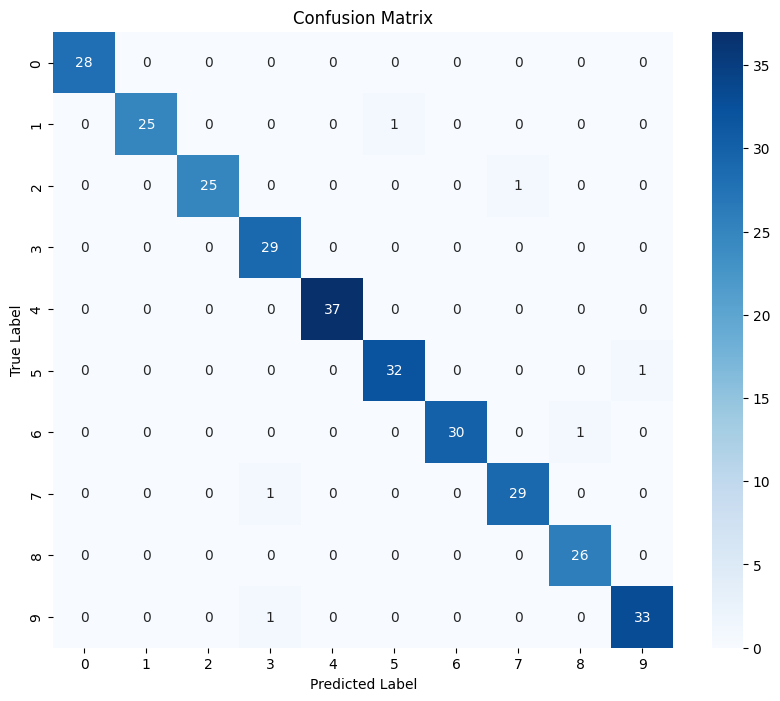

In [12]:
# --- Step 10: Final Evaluation
from sklearn.metrics import accuracy_score # Import the accuracy_score function

print("\n--- Final Evaluation on Test Set ---")
model.load_state_dict(torch.load('best_model.pth'))
y_true, y_pred, y_pred_probs = [], [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))

        # Get raw probabilities from the softmax output
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get the top probability and the predicted class
        top_probs, predicted_classes = torch.max(probabilities, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes.cpu().numpy())
        # Store the confidence score (the probability of the predicted class)
        y_pred_probs.extend(top_probs.cpu().numpy())

# --- NEW: Calculate and print the test accuracy ---
test_accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy:.2%})")
# ----------------------------------------------------

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Plot the Confusion Matrix (code is unchanged)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()

In [13]:
# Install ALL necessary libraries ---
# This includes the powerful dereverberation library
!pip install noisereduce -q

In [41]:
#@title 3. Final, Definitive Real-Time Inference (with History)

# --- Step 1: Import all necessary libraries ---
# These were installed in Cell 1 and are now available after the restart
from google.colab import output
from IPython.display import display, HTML
import torch, torch.nn as nn, torchaudio, torchaudio.transforms as T
import io, base64, traceback, noisereduce as nr, numpy as np

# --- Step 2: Re-define the Model Architecture ---
class DigitRecognizerCNN(nn.Module):
    def __init__(self, input_shape):
        super(DigitRecognizerCNN, self).__init__()
        self.conv_block_1 = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_block_2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_block_3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv_block_3(self.conv_block_2(self.conv_block_1(dummy_input)))
            flattened_size = dummy_output.flatten(1).shape[1]
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(flattened_size, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 10))
    def forward(self, x):
        x = self.conv_block_1(x); x = self.conv_block_2(x); x = self.conv_block_3(x)
        x = self.classifier(x)
        return x

# --- Step 3: Load your trained model ---
device = "cuda" if torch.cuda.is_available() else "cpu"
DUMMY_INPUT_SHAPE_48k = (1, 128, 94)
inference_model_48k = DigitRecognizerCNN(DUMMY_INPUT_SHAPE_48k).to(device)
inference_model_48k.load_state_dict(torch.load('best_model.pth', map_location=device))
inference_model_48k.eval()
print("✅ Final expert model loaded and ready for real-time inference.")

# --- Step 4: Define the full inference pipeline ---
def robust_energy_vad_and_trim(waveform, sample_rate, threshold=0.01):
    frame_size = int(sample_rate * 30 / 1000)
    num_frames = waveform.shape[1] // frame_size
    if num_frames == 0: return torch.tensor([[]])
    energies = [torch.sqrt(torch.mean(waveform[:, i*frame_size:(i+1)*frame_size]**2)).item() for i in range(num_frames)]
    start_frame, end_frame = -1, -1
    for i, energy in enumerate(energies):
        if energy > threshold:
            if start_frame == -1: start_frame = i
            end_frame = i
    if start_frame != -1: return waveform[:, start_frame*frame_size:(end_frame+1)*frame_size]
    return torch.tensor([[]])

def predict_from_audio_data_final(waveform, sample_rate, model):
    # --- ROBUST CLEANING PIPELINE ---
    # 1. Denoise
    waveform_np = waveform.numpy().flatten()
    denoised = nr.reduce_noise(y=waveform_np, sr=sample_rate, stationary=True, prop_decrease=0.8)
    waveform = torch.from_numpy(denoised).float().unsqueeze(0)

    # 2. VAD on the cleaned audio
    waveform_trimmed = robust_energy_vad_and_trim(waveform, sample_rate)
    min_length_for_speech = sample_rate // 5
    if waveform_trimmed.numel() < min_length_for_speech: return {"error": "No significant speech detected."}
    waveform = waveform_trimmed

    # 3. Final Processing and Prediction
    target_len = sample_rate * 1
    if waveform.shape[1] < target_len:
        waveform = torch.nn.functional.pad(waveform, (0, target_len - waveform.shape[1]))
    else:
        waveform = waveform[:, :target_len]
    mel_spec = T.MelSpectrogram(sample_rate=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
    spec = mel_spec(waveform)
    log_spec = torch.log(torch.clamp(spec, min=1e-6))
    input_tensor = log_spec.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    return {"predicted_digit": predicted_class.item(), "confidence": confidence.item()}

# --- Step 5: Main Python callback with error handling ---
def process_and_predict_audio_48k(base64_audio):
    try:
        audio_bytes = base64.b64decode(base64_audio)
        waveform, sr = torchaudio.load(io.BytesIO(audio_bytes))
        target_sr = 48000
        if sr != target_sr: waveform = T.Resample(orig_freq=sr, new_freq=target_sr)(waveform)
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        result = predict_from_audio_data_final(waveform, sample_rate=target_sr, model=inference_model_48k)
        if "error" in result: result_html = f"<h3>Error</h3><p>{result['error']}</p>"
        else: result_html = f"<h3>Predicted Digit: {result['predicted_digit']}</h3><p>Confidence: {result['confidence']:.2%}</p>"
        output.eval_js(f"updateUI('{base64_audio}', `{result_html}`)")
    except Exception:
        error_html = f"<h3>Python Error</h3><pre>{traceback.format_exc()}</pre>"
        output.eval_js(f"updateUI(null, `{error_html}`)")
output.register_callback('notebook.process_and_predict_audio_48k', process_and_predict_audio_48k)

# --- Step 6: HTML and JavaScript front-end ---
HTML('''
<div style="border: 2px solid #333; padding: 20px; text-align: center; font-family: sans-serif;">
    <h2>Spoken Digit Recognition</h2>
    <p>Click Start, say a digit clearly, then click Stop.</p>
    <button id="startButton" style="padding: 10px 20px; font-size: 16px;">Start</button>
    <button id="stopButton" style="padding: 10px 20px; font-size: 16px;" disabled>Stop</button>
    <div id="status" style="margin-top: 15px;">Ready</div>
    <div id="resultsDiv" style="margin-top: 20px; padding: 10px; border-top: 1px solid #ccc; text-align: left;">
        <!-- History will be prepended here -->
    </div>
</div>
<script>
    let mediaRecorder, audioChunks = [];
    const startButton = document.getElementById('startButton'), stopButton = document.getElementById('stopButton');
    const status = document.getElementById('status'), resultsDiv = document.getElementById('resultsDiv');

    // --- MODIFIED FUNCTION TO KEEP HISTORY ---
    function updateUI(base64Audio, predictionHtml) {
        // 1. Create a new container for this entire entry
        const historyEntry = document.createElement('div');
        historyEntry.style.border = '1px solid #ddd';
        historyEntry.style.padding = '10px';
        historyEntry.style.marginTop = '10px';
        historyEntry.style.borderRadius = '5px';
        historyEntry.style.background = '#f9f9f9';

        // 2. Add the prediction text (digit and confidence) to the entry
        const predictionEl = document.createElement('div');
        predictionEl.innerHTML = predictionHtml;
        historyEntry.appendChild(predictionEl);

        // 3. If there is audio, create a player and add it to the entry
        if (base64Audio) {
            const audio = document.createElement('audio');
            audio.controls = true;
            audio.style.marginTop = '5px';
            audio.src = "data:audio/wav;base64," + base64Audio;
            historyEntry.appendChild(audio);
        }

        // 4. Prepend the new entry to the top of the results div, instead of clearing it
        resultsDiv.prepend(historyEntry);
        status.textContent = 'Ready';
    }

    async function startRecording() {
        status.textContent = 'Requesting mic...';
        try {
            const stream = await navigator.mediaDevices.getUserMedia({ audio: { sampleRate: 48000 } });
            mediaRecorder = new MediaRecorder(stream);
            mediaRecorder.ondataavailable = event => { audioChunks.push(event.data); };
            mediaRecorder.onstop = () => {
                const audioBlob = new Blob(audioChunks, { type: 'audio/wav' });
                const reader = new FileReader();
                reader.readAsDataURL(audioBlob);
                reader.onloadend = () => {
                    const base64Audio = reader.result.split(',')[1];
                    status.textContent = 'Processing...';
                    google.colab.kernel.invokeFunction('notebook.process_and_predict_audio_48k', [base64Audio], {});
                };
                audioChunks = [];
            };
            startButton.disabled = true; stopButton.disabled = false;
            status.textContent = 'Recording...'; mediaRecorder.start();
        } catch (err) {
            status.textContent = 'Error: Could not access microphone.';
            console.error(err);
        }
    }
    startButton.onclick = startRecording;
    stopButton.onclick = () => { if(mediaRecorder && mediaRecorder.state === "recording") { mediaRecorder.stop(); startButton.disabled = false; stopButton.disabled = true; } };
</script>
''')

✅ Final expert model loaded and ready for real-time inference.
